# Homework 2, BEE 6940 (Due By 2/23/23, 9:00PM)

**Name**: Parin Bhaduri

**ID**: pbb62

## Overview

### Instructions

- Problem 1 asks you to use `Optimize.optim()` to calibrate a semi-empirical sea-level rise model to temperature and sea-level data.
- Problem 2 asks you to use SNEASY, a Simple Nonlinear EArth SYstem model, to propagate climate-system uncertainty through to sea-level rise.

### Load Environment

The following code loads the environment and makes sure all needed packages are installed. This should be at the start of most Julia scripts.

In [49]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Library/CloudStorage/OneDrive-CornellUniversity/Coding-Assignments/BEE Climate Risk Analysis/Homeworks/hw2-parinbhaduri`


## Problems (Total: 100 Points)

### Problem 1 (60 points)

In this problem, we will work with the semi-empirical sea-level model from [Rahmstorf (2007)](https://doi.org/10.1073/pnas.0907765106). This model links global mean temperature $T(t)$ to global mean sea-level $H(t)$ through the equation:

$$\frac{dH(t)}{dt} = \alpha (T(t) - T_0),$$

where $T_0$ is the temperature (in $^\circ C$) where sea-level is in equilibrium ($dH/dt = 0$), and $\alpha$ is the sea-level rise sensitivity to temperature. Discretizing this equation using the Euler method and using an annual timestep ($\delta t = 1$), we get

$$H(t+1) = H(t) + \alpha (T(t) - T_0).$$

Our goal in this problem is to load temperature and sea-level datasets and *calibrate* the model by finding parameter values which are consistent with historical observations. We will select parameters which minimize the root-mean-square-error (RMSE) of the data-model residuals. The following function can be used to compute the RMSE.

In [14]:
using Statistics, Optim

rmse(y, ŷ) = sqrt(mean((y - ŷ).^2))

rmse (generic function with 1 method)

#### Problem 1.1 (15 points)

Load the sea-level and temperature datasets into `DataFrame`s. The sea-level dataset is provided in `data/CSIRO_Recons_gmsl_yr_2015.csv`, and the temperature dataset is provided in `data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv`. You'll need to correct the years in the sea-level rise data to remove the half-year, and then align the two data sets on the common period 1880 &ndash; 2013. Plot each of the resulting data sets after this "cleaning" process on different axes.

In [15]:
using CSV,DataFrames
#Read in Data 
sea_level = DataFrame(CSV.File("data/CSIRO_Recons_gmsl_yr_2015.csv"))
temperature = DataFrame(CSV.File("data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv"))

#Correct sea_level years
sea_level.Time = Int64.(floor.(sea_level.Time));

#Align time periods for two DataFrames
temperature = temperature[(temperature.Time .>= 1880) .& (temperature.Time .< 2014),:]
sea_level

Row,Time,GMSL (mm),GMSL uncertainty (mm)
,Int64,Float64,Float64
1,1880,-158.7,24.2
2,1881,-153.1,24.2
3,1882,-169.9,23.0
4,1883,-164.6,22.8
5,1884,-143.7,22.2
6,1885,-145.2,21.9
7,1886,-147.6,20.8
8,1887,-153.2,20.8
9,1888,-151.1,20.8


#### Problem 1.2 (30 points)

Write a function for the above model, and find the parameter values which minimize the RMSE using `Optim.optimize()` (here is [documentation on how to use `Optim.optimize()` to minimize a function](https://julianlsolvers.github.io/Optim.jl/v0.9.3/user/minimization/). This will involve writing a function which takes in a vector of parameter values and the data, simulates the model, and computes the RMSE. `Optim.optimize()` maps a parameter vector to a function, and since you'll be passing auxiliary data to your function, you may want to use anonymous function to wrap your simulation function, as in

```julia
optimize(p -> f(p, aux), ...)
```

In [16]:
#Create function for model
function rahmstorf_model(α, T₀, H₀, temp_data)
    temp_effect = α .* (temp_data .- T₀)
    slr_predict = cumsum(temp_effect) .+ H₀
    return slr_predict
end

rahmstorf_model (generic function with 1 method)

In [17]:
years = sea_level.Time
sealevels = sea_level[:,2]
temp = temperature[:,2]

#Create wrapper for function
function minimize_rmse(p, temp, sealevels)
    predict = rahmstorf_model(p[1], p[2], p[3], temp)
    return rmse(predict, sealevels)
end
optim_out = Optim.optimize(p -> minimize_rmse(p, temp, sealevels), [1.0, 0.0, 0.0])
params = Optim.minimizer(optim_out)
@show params;

params = [1.8636596824562823, -0.9711430993147957, -157.33666238607228]


#### Problem 1.3 (15 points)

Plot the sea-level data as points, and overlay a line with the model hindcast. How well do you think the model fits the data? Are there any key trends or features that you notice?

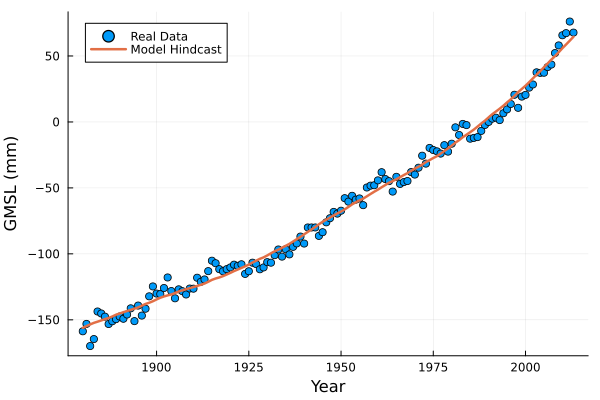

In [18]:
using Plots

#Calculate model hindcast
sea_hind = rahmstorf_model(params[1], params[2], params[3], temp)
scatter(sea_level.Time, sea_level[:,2], label = "Real Data")
plot!(sea_level.Time, sea_hind, label = "Model Hindcast", lw = 2.5)
xlabel!("Year")
ylabel!("GMSL (mm)")

The model fits the data well, tracking its overall trend. However, it's unable to capture the data's variability across the time series, resulting in more of a centralized estimate. More extreme GMSLs above and below the model are not well captured. 

### Problem 2 (40 points)

Your goal in this problem is to see how scenario and parametric uncertainty in climate models propagates through the simple semi-empirical sea-level model from Problem 1. You'll be using SNEASY, and we have provided the same set of functions in `src/sneasy_model_functions.jl` that you used in Lab 3.

#### Problem 2.1 (10 points)

Use 1000 samples from the parameter set for MimiSNEASY (found in `params/parameters_subsample_sneasybrick.csv`) to compute and plot 95% uncertainty intervals for global mean temperatures from 1880 &ndash; 2100 for RCPs 2.6, 4.5, 6.0, and 8.5.

In [19]:
using Mimi
using MimiSNEASY
using Random
using StatsBase

include("src/sneasy_model_functions.jl") # load helper functions
# set up array of model years; this aligns with defaults, but we'll want to use this to query and normalize later
start_year = 1765
end_year = 2100
model_years = collect(start_year:end_year);

parameters = DataFrame(load(joinpath(@__DIR__, "params","parameters_subsample_sneasybrick.csv")))

Row,sd_temp,sd_ocean_heat,sd_glaciers,sd_greenland,sd_antarctic,sd_gmsl,sigma_whitenoise_co2,rho_temperature,rho_ocean_heat,rho_glaciers,rho_greenland,rho_antarctic,rho_gmsl,alpha0_CO2,CO2_0,N2O_0,temperature_0,ocean_heat_0,thermal_s0,greenland_v0,glaciers_v0,glaciers_s0,antarctic_s0,Q10,CO2_fertilization,CO2_diffusivity,heat_diffusivity,rf_scale_aerosol,climate_sensitivity,thermal_alpha,greenland_a,greenland_b,greenland_alpha,greenland_beta,glaciers_beta0,glaciers_n,anto_alpha,anto_beta,antarctic_gamma,antarctic_alpha,antarctic_mu,antarctic_nu,antarctic_precip0,antarctic_kappa,antarctic_flow0,antarctic_runoff_height0,antarctic_c,antarctic_bed_height0,antarctic_slope,antarctic_lambda,antarctic_temp_threshold
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0888643,1.6296,0.000601715,0.000234415,0.000613828,0.00139959,0.17128,0.519427,0.688367,-0.770486,0.853507,0.903597,0.288801,0.0139344,280.705,274.562,0.0567596,-23.219,0.0227005,7.46523,0.488911,-0.0323829,0.0408796,1.15005,0.501621,15.9055,2.49072,1.32597,3.56475,0.18321,-3.74126,8.63759,0.000248228,2.5892e-5,0.000909799,0.885682,0.0026942,1.41176,3.75652,0.0568182,11.0012,0.00804228,1.42741,0.0575641,1.58689,963.524,94.0841,816.366,0.000718302,0.0184998,-15.3685
2,0.0804264,3.43953,6.03675e-5,0.000259227,0.000483527,0.00120834,0.148203,0.51664,0.152661,-0.447865,0.952104,0.874145,0.796842,0.0113726,280.743,281.658,0.0321347,-22.8683,0.0131938,7.24976,0.343998,-0.0246456,0.0517484,1.08471,0.291261,148.596,1.81077,0.776393,1.89759,0.239806,-1.48203,7.84278,0.000626693,0.000167633,0.000905908,0.862802,0.177321,1.40672,2.71454,0.0520832,8.22627,0.0131268,1.28866,0.0676238,0.974234,1169.65,76.6816,781.223,0.000728788,0.00696926,-15.2329
3,0.0864733,3.36641,0.000925258,0.000235204,0.000281876,0.00197216,0.254878,0.539274,0.971248,0.04214,0.926417,0.976046,0.994586,0.0127428,280.584,276.642,-0.00109143,-14.8043,0.0332008,7.43466,0.452955,0.0648781,-0.0167171,1.01532,0.365345,29.9351,5.47466,1.10117,4.07412,0.129787,-1.9962,8.26282,0.000466813,1.64344e-5,0.000986282,0.778852,0.196509,1.21772,4.15967,0.000551198,8.24043,0.0107052,0.682999,0.0747823,1.49117,1809.61,103.641,750.373,0.000580837,0.0117809,-15.4451
4,0.0760894,1.89143,0.000108929,0.000232685,0.0005044,0.00194707,0.183595,0.593196,0.25326,0.418986,0.937166,0.966646,0.839722,0.0107225,278.632,265.246,0.0505959,-20.7595,-0.0035008,7.34913,0.316336,-0.0335558,-0.0460274,3.387,0.748019,16.3465,4.17145,1.343,4.56024,0.16311,-2.3092,8.14753,0.000456689,0.000133752,0.000964376,0.87013,0.022752,0.865006,4.05229,0.110852,9.71629,0.00526472,1.41031,0.0630279,1.44879,846.383,94.7825,792.667,0.000706701,0.00862849,-15.0172
5,0.0846045,2.0082,9.27545e-5,0.000234798,0.000441274,0.00226362,0.309075,0.490472,0.95138,-0.722653,0.877622,0.961373,0.878491,0.0138261,280.825,265.019,-0.0160423,-28.1762,0.0230374,7.20058,0.411835,-0.0433343,0.0410196,1.27931,0.587489,18.1149,2.82943,1.01783,2.98581,0.176383,-1.92462,8.08143,0.000534302,8.27037e-5,0.000696833,0.867485,0.0514347,0.0844522,2.99349,0.465225,7.50141,0.0118415,1.0635,0.0824487,1.16309,977.52,105.748,755.558,0.000668301,0.00998772,-15.316
6,0.0873519,2.19662,7.17012e-5,0.000253082,0.000557583,0.000397221,0.140671,0.361986,0.824862,-0.228841,0.966935,0.964313,0.779158,0.0113983,280.206,274.025,0.0459665,-24.9835,-0.0117678,7.3516,0.512534,-0.0440141,0.0529094,1.00548,0.57727,9.16281,4.19397,1.28677,3.73207,0.156646,-1.39236,7.85344,0.000968325,0.000124742,0.000859203,0.923724,0.0229476,0.660886,4.16103,0.0713564,10.2215,0.0058872,1.30695,0.0519783,1.24124,1906.82,140.486,778.222,0.000742701,0.0109651,-14.8644
7,0.0810219,0.60

In [20]:
function create_sneasy_scenario(rcp::String)
    #Create model object for given scenario
    m_scen = create_sneasy_model(rcp_scenario = rcp, start_year=start_year, end_year=end_year)
    set_sneasy_params!(m_scen, parameters[6340, :], names(parameters))
    return m_scen
end

#Define query query_years
query_years = 1880:2100

1880:2100

In [21]:
#Create model instances and run model
#For 8.5
m_85 = create_sneasy_scenario("RCP85")
run(m_85)

#For 6.0
m_60 = create_sneasy_scenario("RCP60")
run(m_60)

#For 4.5
m_45 = create_sneasy_scenario("RCP45")
run(m_45)

#For 2.6
m_26 = create_sneasy_scenario("RCP26")
run(m_26)

In [22]:
#Calculate global mean temperature for each scenario

temps_85 = query_temperature(m_85, model_years, query_years);
temps_60 = query_temperature(m_60, model_years, query_years);
temps_45 = query_temperature(m_45, model_years, query_years);
temps_26 = query_temperature(m_26, model_years, query_years);

In [23]:
#Create param_space variable
Random.seed!(1)

n_sample = 1000
# get subsample
sample_index = sample(1:nrow(parameters), n_sample, replace=true)
param_sample = parameters[sample_index, :]

#Create function to calculate 95% CIs
function create_temp_quantile(mod, param_space)
    # set up storage for temperatures
    temps = zeros(n_sample, length(query_years))

    # loop over parameters and get temperatures
    for i = 1:n_sample
        set_sneasy_params!(mod, param_space[i, :], names(param_space))
        run(mod)
        temps[i, :] = query_temperature(mod, model_years, query_years)
    end
    # get central 95% interval for each year by picking the 2.5% and 97.5% quantiles
    temp_quantiles = mapslices(x -> quantile(x, [0.025, 0.975]), temps, dims=1)
    return temp_quantiles
end

create_temp_quantile (generic function with 1 method)

In [80]:
quantile_85 = create_temp_quantile(m_85, param_sample)
quantile_60 = create_temp_quantile(m_60, param_sample)
quantile_45 = create_temp_quantile(m_45, param_sample)
quantile_26 = create_temp_quantile(m_26, param_sample)

2×221 Matrix{Float64}:
 0.0109819  0.0161045  0.0117502  …  1.03637  1.04066  1.04619  1.05037
 0.0196472  0.0251864  0.021779      1.72176  1.72827  1.73612  1.74261

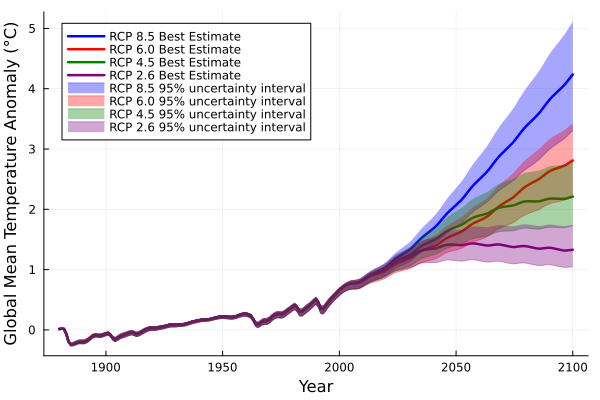

In [81]:
#Plot scenario temperatures
plot(query_years, [temps_85 temps_60 temps_45 temps_26],  color = [:blue :red :green :purple],
label=["RCP 8.5 Best Estimate" "RCP 6.0 Best Estimate" "RCP 4.5 Best Estimate" "RCP 2.6 Best Estimate"], lw =2.5) 
xlabel!("Year")
ylabel!("Global Mean Temperature Anomaly (°C)")

#Plot Uncertainty Intervals for each scenario
plot!(query_years, [quantile_85[1, :] quantile_60[1, :] quantile_45[1, :] quantile_26[1, :]], color = [:blue :red :green :purple], 
fillrange=[quantile_85[2, :] quantile_60[2, :] quantile_45[2, :] quantile_26[2, :]], fillalpha=0.35, alpha =0.35, 
label=["RCP 8.5 95% uncertainty interval" "RCP 6.0 95% uncertainty interval" "RCP 4.5 95% uncertainty interval" "RCP 2.6 95% uncertainty interval"])

#### Problem 2.2 (10 points)

Run your calibrated model from Problem 1 on the ensemble of temperatures for each RCP from Problem 2.1. Plot the 95% uncertainty intervals and the median trajectory from 1880 & ndash;.

In [35]:
#Update create_temp_quantile function to run model across all temp realizaations
#Returns matrix of sea-level realizaations
function create_sea_quantile(mod, param_space, params)
    # set up storage for temperatures
    sea_est = zeros(n_sample, length(query_years))

    # loop over parameters and get temperatures
    #Run model on temperatures
    for i = 1:n_sample
        set_sneasy_params!(mod, param_space[i, :], names(param_space))
        run(mod)
        temp_series = query_temperature(mod, model_years, query_years)
        sea_est[i,:] = rahmstorf_model(params[1], params[2], params[3], temp_series)
    end
    return sea_est
end

create_sea_quantile (generic function with 1 method)

In [36]:
#For 8.5
#Median Trajectory
sl_85 = rahmstorf_model(params[1], params[2], params[3], temps_85)
#95% CI
sea_mat_85 = create_sea_quantile(m_85, param_sample, params)
# get central 95% interval for each year by picking the 2.5% and 97.5% quantiles
sea_quant_85 = mapslices(x -> quantile(x, [0.025, 0.975]), sea_mat_85, dims=1)


2×221 Matrix{Float64}:
 -155.506  -153.666  -151.835  …  589.627  597.589  605.623  613.725
 -155.49   -153.634  -151.783     711.055  721.966  733.004  744.086

In [37]:
#For 6.0
#Median Trajectory
sl_60 = rahmstorf_model(params[1], params[2], params[3], temps_60)
#95% CI
sea_mat_60 = create_sea_quantile(m_60, param_sample, params)
# get central 95% interval for each year by picking the 2.5% and 97.5% quantiles
sea_quant_60 = mapslices(x -> quantile(x, [0.025, 0.975]), sea_mat_60, dims=1)

2×221 Matrix{Float64}:
 -155.506  -153.666  -151.835  …  512.334  518.376  524.458  530.576
 -155.49   -153.634  -151.783     603.877  611.697  619.588  627.527

In [38]:
#For 4.5
#Median Trajectory
sl_45 = rahmstorf_model(params[1], params[2], params[3], temps_45)
#95% CI
sea_mat_45 = create_sea_quantile(m_45, param_sample, params)
# get central 95% interval for each year by picking the 2.5% and 97.5% quantiles
sea_quant_45 = mapslices(x -> quantile(x, [0.025, 0.975]), sea_mat_45, dims=1)

2×221 Matrix{Float64}:
 -155.506  -153.666  -151.835  …  502.956  508.074  513.213  518.368
 -155.49   -153.634  -151.783     597.717  604.675  611.518  618.503

In [39]:
#For 2.6
#Median Trajectory
sl_26 = rahmstorf_model(params[1], params[2], params[3], temps_26)
#95% CI
sea_mat_26 = create_sea_quantile(m_26, param_sample, params)
# get central 95% interval for each year by picking the 2.5% and 97.5% quantiles
sea_quant_26 = mapslices(x -> quantile(x, [0.025, 0.975]), sea_mat_26, dims=1)

2×221 Matrix{Float64}:
 -155.506  -153.666  -151.835  …  452.296  456.308  460.186  463.92
 -155.49   -153.634  -151.783     528.809  533.733  538.717  543.755

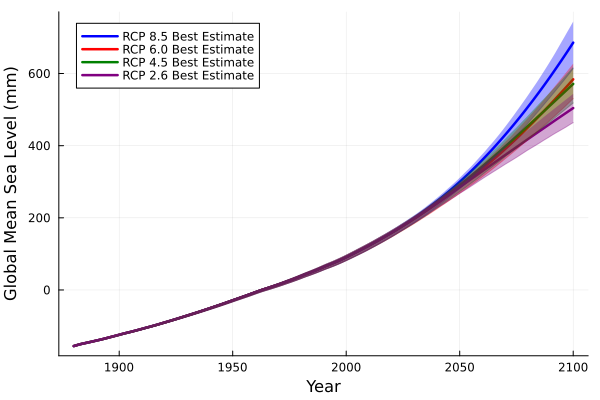

In [58]:
#Plot scenario temperatures
plot(query_years, [sl_85 sl_60 sl_45 sl_26],  color = [:blue :red :green :purple],
label=["RCP 8.5 Best Estimate" "RCP 6.0 Best Estimate" "RCP 4.5 Best Estimate" "RCP 2.6 Best Estimate"], lw =2.5) 
xlabel!("Year")
ylabel!("Global Mean Sea Level (mm)")

#Plot Uncertainty Intervals for each scenario
plot!(query_years, [sea_quant_85[1, :] sea_quant_60[1, :] sea_quant_45[1, :] sea_quant_26[1, :]], color = [:blue :red :green :purple], 
fillrange=[sea_quant_85[2, :] sea_quant_60[2, :] sea_quant_45[2, :] sea_quant_26[2, :]], fillalpha=0.35, alpha =0.35, 
label= false)#["RCP 8.5 95% uncertainty interval" "RCP 6.0 95% uncertainty interval" "RCP 4.5 95% uncertainty interval" "RCP 2.6 95% uncertainty interval"])

#### Problem 2.3 (10 points)

Use [`Plots.density()`](https://docs.juliaplots.org/latest/api/#Plots.density!-Tuple) to plot the distribution of global mean sea levels in 2100 for each RCP (put these density plots on the same axes for easier comparison).

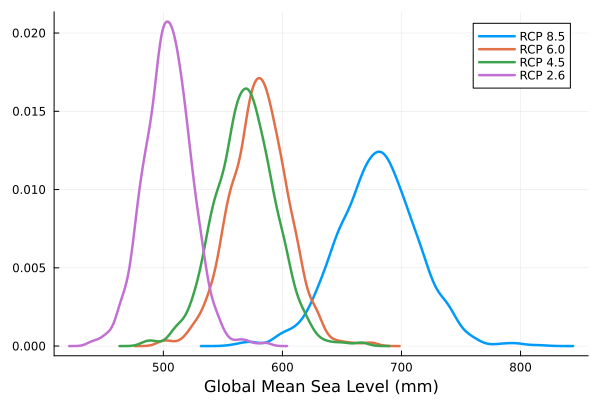

In [56]:
using StatsPlots
density([sea_mat_85[:,221] sea_mat_60[:,221] sea_mat_45[:,221] sea_mat_26[:,221]], labels = ["RCP 8.5" "RCP 6.0" "RCP 4.5" "RCP 2.6"], lw = 2.5)
xlabel!("Global Mean Sea Level (mm)")

#### Problem 2.4 (10 points)

What do you notice about the contributions of parametric and scenario uncertainty to the variability in sea levels over the rest of the century? Are there any interesting trends?

Looking at the Figure in 2.2, we see that sea level hindcasts follow the same trend across all RCP scenarios into the 21st century, but at 2050, the scenario trends begin to deviate and the range of uncertainty vastly increases. By 2100, the predicted global mean sea level (GMSL) can be distinguished by its scenario, with RCP 8.5 predicting the largest increase in GMSL, and RCP 2.6 predicting the smallest. The output ranges vary by scenario, resulting in greater uncertainty in GMSL estimates depending on the RCP Scenario you select.  

There are interesting observations when looking at the distributions of GMSLs in 2100 across all RCPs. Each distribution looks normal, which is expected given the method of parameter sampling, but they are centered around different GMSL values. RCP 2.6 is centered around 500 mm and the centers increase as the RCPs increase. The variances also vary across each distribution, with variance increasing as you increase in RCP scenario. There is broader parametric uncertainty in RCP 8.5 compared to RCP 2.6. These observations could possibly be attributed to the extent to which radiative forcing is influenced by rising emissions. Assuming greater influence would lead to higher GMSLs, but the uncertainty of this calculation would be larger. Alternatively, assuming lesser influence implies that radiative forcing is more influenced by natural climate variability, and thus future GMSLs would be lesser and uncertainty would be reduced as well. 